![header](../../img/logo.svg)

**LSTM Machine Learning Model Demo**

In [1]:
# System libraries
import os
from datetime import timedelta

# Data processing and visulization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Neural Network library
from sklearn.preprocessing import RobustScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Technials Analysis library
os.chdir("../technicals")
import technicals

# Market data connection library
os.chdir("../marketdata")
import alpaca

---

## Model Training

### *Market Data*

In [2]:
# Set market data date range 
from datetime import date, datetime, timedelta

end_date  = datetime.now()
start_date  = (end_date - timedelta(days=1000))

start_date = start_date.strftime('%Y-%m-%d')
end_date = end_date.strftime('%Y-%m-%d')

print(f"Start date : {start_date}")
print(f"End date : {end_date}")

Start date : 2018-10-17
End date : 2021-07-13


In [3]:
# Load the dataset
test_tickers = ["KO"]

In [4]:
ohlcv_df = alpaca.ohlcv(test_tickers, start_date=start_date, end_date=end_date)
tech_ind = technicals.TechnicalAnalysis(ohlcv_df)

df = tech_ind.get_all_technicals(test_tickers[0])
df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)
df.head()

C:\Users\illya\anaconda3\envs\cu_proj_2\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,close,rsi,williams,mfi,stoch_k,macd,ma_10,ma_50,ma_200,ema_7,ema_14,ema_21,highlow,closeopen,bb_high,bb_low,pvt
time,,,,,,,,,,,,,,,,,
2018-10-17 00:00:00-04:00,45.855,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,45.855000,45.855000,45.855000,0.630,0.445,0.0,0.0,0.000000
2018-10-18 00:00:00-04:00,45.640,0.000000,0.0,0.0,0.0,-0.004824,0.0,0.0,0.0,45.732143,45.739821,45.742381,0.625,-0.260,0.0,0.0,0.000000
2018-10-19 00:00:00-04:00,46.320,18.428184,0.0,0.0,0.0,0.014940,0.0,0.0,0.0,45.986351,45.961452,45.953535,0.670,0.500,0.0,0.0,209289.659307
2018-10-22 00:00:00-04:00,45.960,16.684192,0.0,0.0,0.0,0.010566,0.0,0.0,0.0,45.976714,45.961008,45.955389,0.645,-0.410,0.0,0.0,-233880.743235
2018-10-23 00:00:00-04:00,46.360,25.120382,0.0,0.0,0.0,0.023883,0.0,0.0,0.0,46.102350,46.065104,46.052421,1.005,0.740,0.0,0.0,191979.332017


---

### *Data pre-processing : Scaling*

#### Scaling using [RobustScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html):

Scale features using statistics that are robust to outliers.

This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Median and interquartile range are then stored to be used on later data using the transform method.

Standardization of a dataset is a common requirement for many machine learning estimators. Typically this is done by removing the mean and scaling to unit variance. However, outliers can often influence the sample mean / variance in a negative way. In such cases, the median and the interquartile range often give better results.

In [5]:
# scale fitting the close prices separately for inverse_transformations purposes later
close_scaler = RobustScaler()
close_scaler.fit(df[['close']])

RobustScaler()

In [6]:
scaler = RobustScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

In [7]:
df.head()

,close,rsi,williams,mfi,stoch_k,macd,ma_10,ma_50,ma_200,ema_7,ema_14,ema_21,highlow,closeopen,bb_high,bb_low,pvt
time,,,,,,,,,,,,,,,,,
2018-10-17 00:00:00-04:00,-0.746330,-3.907298,0.768752,-2.887022,-0.524568,-0.351337,-8.191309,-7.74375,-0.966171,-0.691221,-0.674866,-0.696254,-0.106293,0.781956,-9.840013,-7.721796,-0.016283
2018-10-18 00:00:00-04:00,-0.781403,-3.907298,0.768752,-2.887022,-0.524568,-0.358168,-8.191309,-7.74375,-0.966171,-0.710811,-0.693354,-0.715126,-0.116922,-0.471378,-9.840013,-7.721796,-0.016283
2018-10-19 00:00:00-04:00,-0.670473,-2.567937,0.768752,-2.887022,-0.524568,-0.330179,-8.191309,-7.74375,-0.966171,-0.670278,-0.657779,-0.679742,-0.021259,0.879733,-9.840013,-7.721796,0.903756
2018-10-22 00:00:00-04:00,-0.729201,-2.694691,0.768752,-2.887022,-0.524568,-0.336374,-8.191309,-7.74375,-0.966171,-0.671814,-0.657850,-0.679431,-0.074405,-0.738044,-9.840013,-7.721796,-1.044425
2018-10-23 00:00:00-04:00,-0.663948,-2.081548,0.768752,-2.887022,-0.524568,-0.317515,-8.191309,-7.74375,-0.966171,-0.651782,-0.641141,-0.663171,0.690901,1.306400,-9.840013,-7.721796,0.827659


---

### *LSTM Model Helper Functions*

1. split_sequence() - splits multivariate time sequences for LSTM training
2. add_hidded_layers() - adds requested number of LSTM hidden layers with requested number of nodes
3. validater() - validates training results
4. rmse() - returns root-mean-squared error

In [8]:
# LSTM Helper Functions
def split_sequence(sequence, n_in, n_out):
    '''
    Splits the multivariate time sequence

    Parameters
    ----------
    sequence : np.array
        numpy array of the dataframe used to train the model

    Returns
    -------
    X, y : np.array
        Time sequence values for X and y portions of the dataset
    '''
    
    # creating a list for both variables
    X, y = [], []
    
    for i in range(len(sequence)):
        
        # finding the end of the current sequence
        end = i + n_in
        out_end = end + n_out
        
        # breaking out of the loop if we have exceeded the dataset's length
        if out_end > len(sequence):
            break
        
        # splitting the sequences into: x = past prices and indicators, y = prices ahead
        sequence_x, sequence_y = sequence[i:end, :], sequence[end:out_end, 0]
        
        X.append(sequence_x)
        y.append(sequence_y)
    
    return np.array(X), np.array(y)
    
    
def add_hidden_layers(n_layers, n_nodes, activation, drop=None, drop_rate=.5):
    '''
    Creates a specific amount of hidden layers for the model

    Parameters
    ----------
    n_layers : int
        number of layers to be added to the model

    n_nodes : int
        number of nodes to be added to each layer

    activation : str
        activation function used by each layers in the model
        Full list of all activation functions: 
            https://www.tensorflow.org/api_docs/python/tf/keras/activations

    drop : int
        every n-th hidden layer after which a Dropout layer to be added

    drop_rate : float
        rate for each Dropout layer
        default = 0.5

    '''
    
    # creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # adds a Dropout layer after every n-th hidden layer
        try:
            if x % drop == 0:
                model.add(Dropout(drop_rate))
        except:
            pass
    
    
def validater():
    '''
    Creates predicted values.

    Returns
    -------
    predictions : pd.DataFrame
        Predicted values for the model
    '''
    
    # Creating an empty DF to store the predictions
    predictions = pd.DataFrame(index=df.index, columns=[df.columns[0]])

    for i in range(n_in, len(df)-n_in, n_out):
        # Creating rolling intervals to predict off of
        x = df[-i - n_in:-i]

        # Predicting using rolling intervals
        y_pred = model.predict(np.array(x).reshape(1, n_in, n_features))

        # Transforming values back to their normal prices
        y_pred = close_scaler.inverse_transform(y_pred)[0]

        # DF to store the values and append later, frequency uses business days
        pred_df = pd.DataFrame(y_pred, 
                               index=pd.date_range(start=x.index[-1], 
                                                   periods=len(y_pred), 
                                                   freq="B"),
                               columns=[x.columns[0]])

        # Updating the predictions DF
        predictions.update(pred_df)
        
    return predictions


def rmse(df_actual, df_predicted):
    '''
    Calculates the RMS (root mean square) error between the two pd.Dataframes
    
    Parameters
    ----------
    df_actual : pd.DataFrame
        DataFrame with Actual Closing prices
    df_predicted : pd.DataFrame
        DataFrame with Predicted Closing prices
    
    '''
    df = df_actual.copy()
    df['close_pred'] = df_predicted['close']
    df.dropna(inplace=True)
    df['diff'] = df['close']- df['close_pred']
    rms = (df[['diff']]**2).mean()
    error = float(np.sqrt(rms))
    
    return error

### *LSTM Visualization Functions*

1. visualize_training_results() - plots validation loss, loss, validation accuracy, and accuracy
2. visualize_training_price() - plots actual and predicted Closing stock price

In [22]:
def visualize_training_results(results, model_loss_filename : str, model_accuracy_filename : str):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(16,5))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.savefig(model_loss_filename)
    plt.show()
    
    plt.figure(figsize=(16,5))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    

    plt.savefig(model_accuracy_filename)
    plt.show()
    
def visualize_training_price(filename):
    '''
    Visualizes Actual vs. Predicted stock price
    '''

    # Transforming the actual values to their original price
    actual = pd.DataFrame(close_scaler.inverse_transform(df[["close"]]), 
                          index=df.index, 
                          columns=[df.columns[0]])

    # Getting a DF of the predicted values to validate against
    predictions = validater()

    # Printing the RMSE
    print(f"RMSE: {rmse(actual, predictions)}")

    # Plotting
    plt.figure(figsize=(16,6))

    # Plotting those predictions
    plt.plot(predictions, label='Predicted')

    # Plotting the actual values
    plt.plot(actual, label='Actual')

    plt.title(f"Predicted vs Actual Closing Prices")
    plt.ylabel("Price")
    plt.legend()
    
    plt.savefig(filename)
    plt.show()

---

### *Building LSTM Model*

Builds an LSMT model, compiles and fits it.

* Looks back 100 days to predict 14 days
* Sequential() model - groups a linear stack of layers into a [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model) : [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)
* Uses Hyperbolic tangent activation function : [tf.keras.activations.tanh](https://www.tensorflow.org/api_docs/python/tf/keras/activations/tanh)
* Composed of LSTM input and hidden layers - Long Short-Term Memory layer - [Hochreiter 1997](https://dl.acm.org/doi/10.1162/neco.1997.9.8.1735): [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)
* Uses Adam optimzer - a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments : [tf.keras.optimizers.Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
* Uses Mean Squared Error loss function - computes the mean of squares of errors between labels and predictions: [tf.keras.losses.MeanSquaredError](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanSquaredError)
* Model is trained for 50 epochs using 128 unit batch size

In [10]:
# n periods looking back to learn
n_in  = 100

# n periods to predict
n_out = 14

# n features 
n_features = df.shape[1]

# X, y split
X, y = split_sequence(df.to_numpy(), n_in, n_out)

# Dataframe for predictions
predictions = None

In [11]:
# instatiating the model
model = Sequential()

In [12]:
# activation
activation_func = "tanh"

In [13]:
# add input layer
model.add(LSTM(90, 
               activation=activation_func, 
               return_sequences=True, 
               input_shape=(n_in, n_features)))

In [14]:
# add hidden layers
add_hidden_layers(n_layers=1, 
                  n_nodes=30, 
                  activation=activation_func)

In [15]:
# add final Hidden layer
model.add(LSTM(60, activation=activation_func))

In [16]:
# add output layer
model.add(Dense(n_out))

In [17]:
# print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 90)           38880     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 30)           14520     
_________________________________________________________________
lstm_2 (LSTM)                (None, 60)                21840     
_________________________________________________________________
dense (Dense)                (None, 14)                854       
Total params: 76,094
Trainable params: 76,094
Non-trainable params: 0
_________________________________________________________________


In [18]:
# compile model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [19]:
# fit and train the model
res = model.fit(X, y, epochs=50, batch_size=128, validation_split=0.1)

Epoch 1/50
5/5 [==============================] - 24s 536ms/step - loss: 0.3584 - accuracy: 0.0463 - val_loss: 0.2506 - val_accuracy: 0.0690
Epoch 2/50
5/5 [==============================] - 1s 195ms/step - loss: 0.2551 - accuracy: 0.0517 - val_loss: 0.1050 - val_accuracy: 0.0690
Epoch 3/50
5/5 [==============================] - 1s 197ms/step - loss: 0.2081 - accuracy: 0.0581 - val_loss: 0.0639 - val_accuracy: 0.1034
Epoch 4/50
5/5 [==============================] - 1s 191ms/step - loss: 0.1562 - accuracy: 0.0925 - val_loss: 0.0970 - val_accuracy: 0.1207
Epoch 5/50
5/5 [==============================] - 1s 197ms/step - loss: 0.1473 - accuracy: 0.1046 - val_loss: 0.0297 - val_accuracy: 0.1379
Epoch 6/50
5/5 [==============================] - 1s 194ms/step - loss: 0.1155 - accuracy: 0.1096 - val_loss: 0.0211 - val_accuracy: 0.0862
Epoch 7/50
5/5 [==============================] - 1s 200ms/step - loss: 0.0912 - accuracy: 0.0889 - val_loss: 0.0381 - val_accuracy: 0.0862
Epoch 8/50
5/5 [===

---

### *Visualize Training Results*

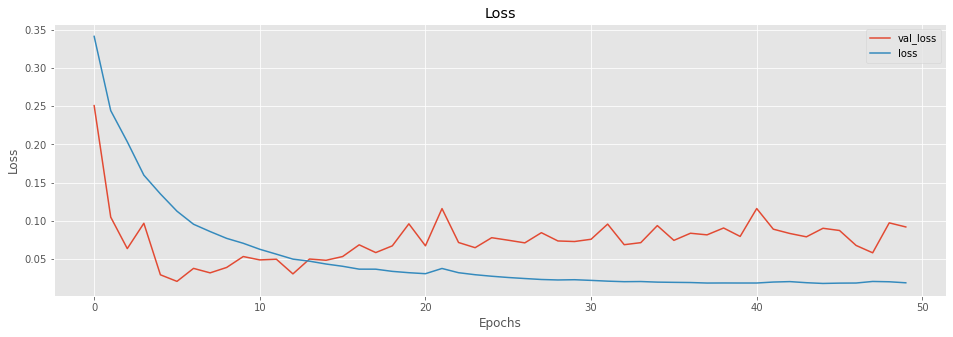

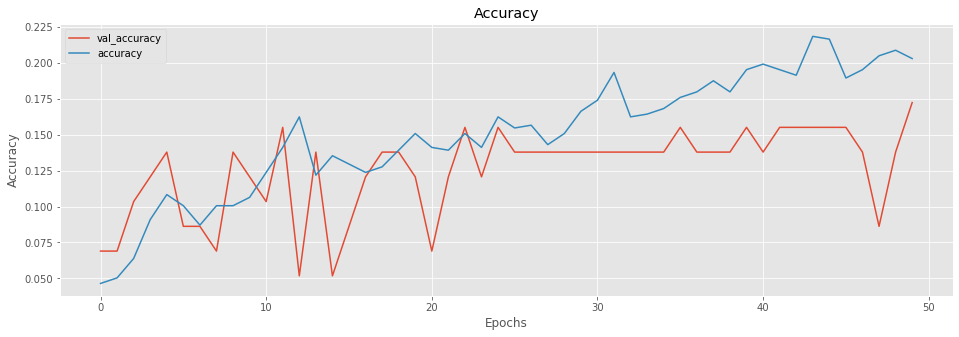

In [23]:
os.chdir("../ml/savedmodels")
visualize_training_results(res, model_loss_filename="model_loss_KO.png", model_accuracy_filename="model_accuracy_KO.png")

RMSE: 0.913955813054147


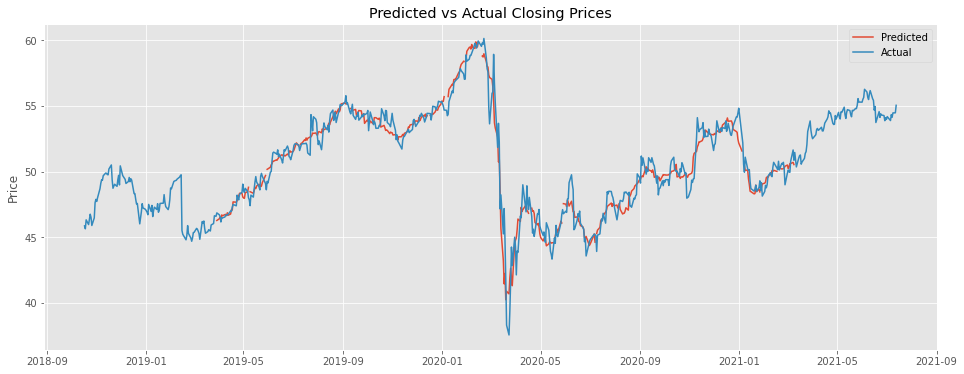

In [24]:
visualize_training_price(filename="pred_prices_KO.png")

---

### *Save model*

In [26]:
model.save("proj2_demo_model_KO.h5")

---

## Forecasting future stock price

### *Get market data*

In [27]:
# Set market data date range 
from datetime import date, datetime, timedelta

pred_end_date  = datetime.now()
pred_start_date  = (pred_end_date - timedelta(days=200))

pred_start_date = pred_start_date.strftime('%Y-%m-%d')
pred_end_date = pred_end_date.strftime('%Y-%m-%d')

print(f"Forecast start date : {pred_start_date}")
print(f"Forecast end date : {pred_end_date}")

Forecast start date : 2020-12-25
Forecast end date : 2021-07-13


In [28]:
# Load the dataset
pred_ohlcv_df = alpaca.ohlcv(test_tickers, start_date=pred_start_date, end_date=pred_end_date)

pred_tech_ind = technicals.TechnicalAnalysis(pred_ohlcv_df)

pred_df = pred_tech_ind.get_all_technicals(test_tickers[0])

pred_df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)

pred_df.head()

C:\Users\illya\anaconda3\envs\cu_proj_2\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,close,rsi,williams,mfi,stoch_k,macd,ma_10,ma_50,ma_200,ema_7,ema_14,ema_21,highlow,closeopen,bb_high,bb_low,pvt
time,,,,,,,,,,,,,,,,,
2020-12-28 00:00:00-05:00,54.15,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,54.150000,54.150000,54.150000,0.705,0.30,0.0,0.0,0.000000
2020-12-29 00:00:00-05:00,54.14,0.000000,0.0,0.0,0.0,-0.000224,0.0,0.0,0.0,54.144286,54.144643,54.144762,0.470,-0.31,0.0,0.0,0.000000
2020-12-30 00:00:00-05:00,54.45,68.888889,0.0,0.0,0.0,0.009327,0.0,0.0,0.0,54.276486,54.261290,54.256344,0.600,0.40,0.0,0.0,38908.803368
2020-12-31 00:00:00-05:00,54.82,83.459916,0.0,0.0,0.0,0.026802,0.0,0.0,0.0,54.475257,54.432215,54.417996,0.660,0.37,0.0,0.0,4505.042909
2021-01-04 00:00:00-05:00,52.76,21.998729,0.0,0.0,0.0,-0.046240,0.0,0.0,0.0,53.913022,53.995937,54.020382,2.600,-1.51,0.0,0.0,-876475.987663


### *Data pre-processing : Scaling*

In [29]:
pred_scaler = RobustScaler()
transformed_pred_df = pd.DataFrame(pred_scaler.fit_transform(pred_df), 
                       columns=pred_df.columns, 
                       index=pred_df.index).tail(n_in)

In [30]:
transformed_pred_df.head()

,close,rsi,williams,mfi,stoch_k,macd,ma_10,ma_50,ma_200,ema_7,ema_14,ema_21,highlow,closeopen,bb_high,bb_low,pvt
time,,,,,,,,,,,,,,,,,
2021-02-19 00:00:00-05:00,-0.804033,-0.300084,0.182386,0.245470,-0.003532,-0.146811,-0.609966,-0.947427,0.0,-0.740818,-0.748788,-0.696865,0.661451,-1.310367,-0.816351,-0.340424,-1.606676
2021-02-22 00:00:00-05:00,-0.678009,-0.041612,0.547555,0.590552,0.531513,-0.090268,-0.583080,-0.947427,0.0,-0.713933,-0.725580,-0.678550,1.671408,1.331835,-0.778355,-0.338821,1.235274
2021-02-23 00:00:00-05:00,-0.698173,-0.087759,0.028575,0.595159,0.112485,-0.058963,-0.559342,-0.947427,0.0,-0.698822,-0.708187,-0.663868,1.330014,-0.925046,-0.755228,-0.319780,-0.772656
2021-02-24 00:00:00-05:00,-0.657845,-0.002391,0.158420,0.587367,0.159509,-0.019045,-0.544083,-0.947427,0.0,-0.677384,-0.687740,-0.646830,0.419630,0.487798,-0.725587,-0.307842,0.193468
2021-02-25 00:00:00-05:00,-0.791430,-0.317139,-0.572679,0.241096,-0.300870,-0.055703,-0.519376,-0.947427,0.0,-0.694778,-0.687884,-0.643820,0.405405,-0.631468,-0.714172,-0.300735,-0.940652


In [31]:
# transform technical analysis data to np.array
pred_arr = np.array(transformed_pred_df).reshape(1, n_in, n_features)

### *Forecast stock price*

In [32]:
# load model
from tensorflow.keras.models import load_model
forecast_model = load_model("proj2_demo_model_KO.h5")

In [33]:
# predicting off of the new data
pred_y = forecast_model.predict(pred_arr)

In [34]:
# inverse_transform the predicted values back to original scale
pred_y = close_scaler.inverse_transform(pred_y)[0]

In [35]:
# parse perdicted values to pd.DataFrame, adjust date scale (index)
preds = pd.DataFrame(pred_y, 
                     index=pd.date_range(start=df.index[-1]+timedelta(days=1), 
                                         periods=len(pred_y), 
                                         freq="B"), 
                     columns=[df.columns[0]])

### *Plot the results*

In [36]:
# get actual historical prices
actual = pred_df[["close"]].tail(n_in)

In [37]:
# get company name from ticker
# Source: https://stackoverflow.com/questions/38967533/retrieve-company-name-with-ticker-symbol-input-yahoo-or-google-api
import requests

def get_company_name(ticker):
    url = "http://d.yimg.com/autoc.finance.yahoo.com/autoc?query={}&region=1&lang=en".format(ticker)

    result = requests.get(url).json()

    for x in result['ResultSet']['Result']:
        if x['symbol'] == ticker:
            return x['name']

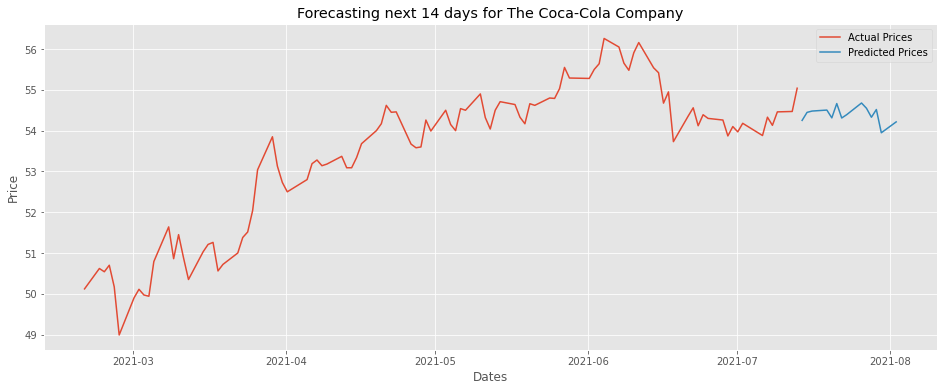

In [41]:
# plot results
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting next {len(pred_y)} days for {get_company_name(test_tickers[0])}")
plt.legend()

plt.savefig("model_forecast_KO.png")
plt.show()

In [40]:
preds

,close
2021-07-14 00:00:00-04:00,54.251240
2021-07-15 00:00:00-04:00,54.447819
2021-07-16 00:00:00-04:00,54.479839
2021-07-19 00:00:00-04:00,54.504448
2021-07-20 00:00:00-04:00,54.313118
2021-07-21 00:00:00-04:00,54.663982
2021-07-22 00:00:00-04:00,54.310127
2021-07-23 00:00:00-04:00,54.390736
2021-07-26 00:00:00-04:00,54.677582
2021-07-27 00:00:00-04:00,54.548965
